### EDIT LOG
- v1 simple fitting into dataset first, did encoding, but wrong kinds. performed SMOTE on train data
- v2 encoded categorical columns, tried grouping the profession categories due to high cardinality. to try reducing cadinality and finetune in next version

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score


import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

#### Reading csv file

In [2]:
df = pd.read_csv("loanprediction.csv")
# df.head()

#### Drop column(s)

In [3]:
df.drop("Id", axis=1, inplace=True)
# df.drop("state", axis=1)
# df.drop("city", axis=1)

#### Renaming columns

In [4]:
df.columns = ["income", "age", "experience", "marital_status", "house_ownership", "car_ownership", "profession", "city", "state", "current_job_years", "current_house_years", "risk_flag"]
# df.head()

#### Check the number of unique category for each categorical column

In [17]:
cat_cols = ["marital_status", "house_ownership", "car_ownership", "profession", "city", "state"]

# technology - Web_designer, Software_Developer, , Computer_operator, Technology_specialist
# medical - Physician, Microbiologist, Dentist, Surgeon, Psychologist
# analyst - Financial_Analyst, Analyst
# engineer - Computer_hardware_engineer, Industrial_Engineer, Mechanical_engineer, Chemical_engineer, Biomedical_Engineer, Petroleum_Engineer, Design_Engineer, Civil_engineer, Engineer, Technician
# aviation - Flight_attendant, Air_traffic_controller, Aviator
# government - Civil_servant, Official, Politician, Army_officer, Police_officer
# designer - Designer, Graphic_Designer, Fashion_Designer
# court - Magistrate, Lawyer
# architectural - Architect, Drafter


# 'Technical_writer',
# 'Librarian', 'Economist', 
# 'Artist', 'Surveyor', 
# 'Hotel_Manager', 'Comedian', 'Secretary', 
# 'Chartered_Accountant', 'Firefighter', 
# 'Geologist','Statistician', '
# 'Consultant', 'Chef', 'Scientist'

#### Label encoding categorical columns with 2 types of categories

In [6]:
label_enc = LabelEncoder()
df["marital_status"] = label_enc.fit_transform(df["marital_status"])
df["car_ownership"] = label_enc.fit_transform(df["car_ownership"])

#### One Hot Encoding `house_ownership` column & Combining back to dataframe

In [7]:
onehot_enc = OneHotEncoder()
house_ownership_reshape = np.array(df["house_ownership"]).reshape(-1, 1)
house_ownership_values = onehot_enc.fit_transform(house_ownership_reshape).toarray().astype(int)
house_ownership_labels = np.array(["norent_noown", "owned", "rented"]).ravel()
house_ownership_df = pd.DataFrame(house_ownership_values, columns=house_ownership_labels)

df = df.join(house_ownership_df["norent_noown"])
df = df.join(house_ownership_df["owned"])
df = df.join(house_ownership_df["rented"])

df.drop("house_ownership", axis=1, inplace=True)

df.head()

,income,age,experience,marital_status,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag,norent_noown,owned,rented
0,1303834,23,3,1,0,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,0,0,1
1,7574516,40,10,1,0,Software_Developer,Parbhani,Maharashtra,9,13,0,0,0,1
2,3991815,66,4,0,0,Technical_writer,Alappuzha,Kerala,4,10,0,0,0,1
3,6256451,41,2,1,1,Software_Developer,Bhubaneswar,Odisha,2,12,1,0,0,1
4,5768871,47,11,1,0,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,0,0,1


#### Target Encoding the high cardinality categorical columns: `profession`, `city`, `state`

In [8]:
# https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64

target_enc = TargetEncoder()
df["profession_encoded"] = target_enc.fit_transform(df["profession"], df["risk_flag"])

/Users/jonw/miniforge3/envs/ml_env/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [9]:
target_enc = TargetEncoder()
df["city_encoded"] = target_enc.fit_transform(df["city"], df["risk_flag"])

In [10]:
target_enc = TargetEncoder()
df["state_encoded"] = target_enc.fit_transform(df["state"], df["risk_flag"])

df.drop("profession", axis=1, inplace=True)
df.drop("city", axis=1, inplace=True)
df.drop("state", axis=1, inplace=True)
df.head()

,income,age,experience,marital_status,car_ownership,current_job_years,current_house_years,risk_flag,norent_noown,owned,rented,profession_encoded,city_encoded,state_encoded
0,1303834,23,3,1,0,3,13,0,0,0,1,0.111558,0.121554,0.154369
1,7574516,40,10,1,0,9,13,0,0,0,1,0.148427,0.122497,0.113254
2,3991815,66,4,0,0,4,10,0,0,0,1,0.134167,0.130814,0.167097
3,6256451,41,2,1,1,2,12,1,0,0,1,0.148427,0.326194,0.142550
4,5768871,47,11,1,0,3,14,1,0,0,1,0.115794,0.121137,0.103163


#### Defining x and y (target) variables

In [11]:
y = df["risk_flag"]
x = df.drop("risk_flag", axis=1)

#### Splitting the dataset into train and test sets

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 2021)

#### Perform oversampling on train data

<AxesSubplot:xlabel='risk_flag', ylabel='count'>

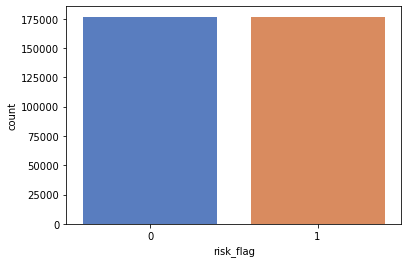

In [14]:
oversampler = SMOTE()
x_train, y_train = oversampler.fit_resample(x_train, y_train)

sns.countplot(x = y_train, palette = 'muted')

#### Applying xgboost model

In [15]:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
xgb = XGBClassifier(learning_rate=0.1,
                    n_estimators=1000,
                    use_label_encoder=False,
                    random_state=2021)

xgb.fit(x_train, y_train, eval_metric='logloss')
y_pred = xgb.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

In [16]:
print("-------------------------TEST SCORES-----------------------")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"AUC Score: {roc_auc_score(y_test, y_pred)}")

-------------------------TEST SCORES-----------------------
Recall: 0.7781418974274946
Precision: 0.5386185777475332
F1-Score: 0.6365951742627347
Accuracy score: 0.892420634920635
AUC Score: 0.8431536179690017


-------------------------TEST SCORES----------------------- \
Recall: 0.7781418974274946 \
Precision: 0.5386185777475332 \
F1-Score: 0.6365951742627347 \
Accuracy score: 0.892420634920635 \
AUC Score: 0.8431536179690017